# Fig9: Supplementary conditional correlations in the STG

In [1]:
import numpy as np
import matplotlib.pylab as plt
import delfi.distribution as dd
import time
from copy import deepcopy
import sys
sys.path.append("../fig8_stg/model/setup")
sys.path.append("../fig8_stg/model/simulator")
sys.path.append("../fig8_stg/model/inference")
sys.path.append("../fig8_stg/model/visualization")
sys.path.append("../fig8_stg/model/utils")

import sys; sys.path.append('../')
from common import col, svg, plot_pdf, samples_nd, buildCondCovMatrix, extractSpecificCondCorr

import netio
import viz
import importlib
import viz_samples
import train_utils as tu

import matplotlib as mpl

%load_ext autoreload
%autoreload 2

In [68]:
PANEL_X  = 'svg/31D_panel_x.svg'
PANEL_Y1 = 'svg/31D_panel_y1.svg'
PANEL_Y2 = 'svg/31D_panel_y2.svg'
PANEL_Y3 = 'svg/31D_panel_y3.svg'
PANEL_Y4 = 'svg/31D_panel_y4.svg'
PANEL_Z1 = 'svg/31D_panel_z1.svg'
PANEL_Z2 = 'svg/31D_panel_z2.svg'

### Load samples

In [3]:
params = netio.load_setup('train_31D_R1_BigPaper')

In [4]:
filedir = "../fig8_stg/results/31D_samples/pyloricsamples_31D_noNaN_3.npz"
pilot_data, trn_data, params_mean, params_std = tu.load_trn_data_normalize(filedir, params)
print('We use', len(trn_data[0]), 'training samples.')

stats = trn_data[1]
stats_mean = np.mean(stats, axis=0)
stats_std  = np.std(stats, axis=0)

We use 170000 training samples.


### Load network

In [5]:
date_today = '1908208'
import dill as pickle
with open('../fig8_stg/results/31D_nets/191001_seed1_Exper11deg.pkl', 'rb') as file:
    inf_SNPE_MAF, log, params = pickle.load(file)
params = netio.load_setup('train_31D_R1_BigPaper')

In [6]:
prior = netio.create_prior(params, log=True)
dimensions = np.sum(params.use_membrane) + 7
lims = np.asarray([-np.sqrt(3)*np.ones(dimensions), np.sqrt(3)*np.ones(dimensions)]).T

In [7]:
prior = netio.create_prior(params, log=True)
params_mean = prior.mean
params_std = prior.std

In [8]:
from find_pyloric import merge_samples, params_are_bounded

labels_ = viz.get_labels(params)
prior_normalized = dd.Uniform(-np.sqrt(3)*np.ones(dimensions), np.sqrt(3)*np.ones(dimensions), seed=params.seed)

### Load experimental data

In [9]:
summstats_experimental = np.load('../fig8_stg/results/31D_experimental/190807_summstats_prep845_082_0044.npz')['summ_stats']

### Calculate posterior

In [10]:
from find_pyloric import merge_samples, params_are_bounded

all_paths = []
all_posteriors = []
labels_ = viz.get_labels(params)

posterior_MAF = inf_SNPE_MAF.predict([summstats_experimental]) # given the current sample, we now predict the posterior given our simulation outcome. Note that this could just be overfitted.

### Load samples

In [11]:
samples_MAF = merge_samples("../fig8_stg/results/31D_samples/02_cond_vals", name='conductance_params')
samples_MAF = np.reshape(samples_MAF, (1000*2520, 31))
print(np.shape(samples_MAF))

(2520000, 31)


### Load start and end point

In [12]:
num_to_watch = 3
infile = '../fig8_stg/results/31D_pairs/similar_and_good/sample_pair_{}.npz'.format(num_to_watch) # 0 is shitty
npz = np.load(infile)
start_point = npz['params1']
end_point = npz['params2']

In [13]:
start_point_unnorm = start_point * params_std + params_mean
end_point_unnorm   = end_point   * params_std + params_mean
ratio = end_point_unnorm / start_point_unnorm
run_true = (ratio > np.ones_like(ratio) * 2.0) | (ratio < np.ones_like(ratio) / 2.0)

In [14]:
print(run_true)

[ True  True False  True False False  True False False False False  True
  True False False False False False False False  True False  True False
 False False False False False False False]


In [15]:
lims = np.asarray([-np.sqrt(3)*np.ones(dimensions), np.sqrt(3)*np.ones(dimensions)]).T
#lims[-7,1] -= 2*np.sqrt(3)/6

In [16]:
def extract_1D_hist(sampels_MAF, dim, num_bins):
    hist1D, _ = np.histogram(samples_MAF[:,dim], bins=np.linspace(-np.sqrt(3), np.sqrt(3), num_bins))
    return hist1D

In [17]:
def sample_1D_hist(hist, num_samples, num_bins):
    cumsum = np.cumsum(hist)
    cumsum = cumsum / cumsum[-1]
    rand_var = np.random.rand(num_samples)
    
    samples = []
    for r in rand_var:
        a = np.abs(r - cumsum)
        index_of_min = np.argmin(a)
        samples.append(index_of_min)
    
    samples = (np.asarray(samples) / (num_bins-1) * 2 * np.sqrt(3)) - np.sqrt(3)
    return samples

In [18]:
def draw_independent_theta(num_samples=1):
    theta = []
    for dim in range(31):
        num_bins = 1000
        myhist = extract_1D_hist(samples_MAF, dim, num_bins=num_bins)
        theta.append(sample_1D_hist(myhist, num_samples, num_bins))
    theta = np.asarray(theta).T
    return theta

In [19]:
#import time
##start_time = time.time()
#thetas = draw_independent_theta(num_samples=100000)
#print('overall time:  ', time.time()-start_time)

overall time:   28.722280263900757


In [51]:
#np.savez('results/factorized_posteriorSamples.npz', thetas=thetas)

In [52]:
thetas = np.load('results/factorized_posteriorSamples.npz')['thetas']

In [21]:
from decimal import Decimal
all_labels = []
for dim_i in range(31):
    if dim_i > len(params_mean) - 7.5: # synapses
        if dim_i == 24: all_labels.append([r'$\mathdefault{0.01}$   ', r'$\mathdefault{10000}\;\;\;\;$   '])
        else: all_labels.append([r'$\;\;\mathdefault{0.01}$', r'$\mathdefault{1000}\;\;\;\;$ '])
    else: # membrane conductances
        num_after_digits = -int(np.log10(lims[dim_i, 1] * params_std[dim_i] + params_mean[dim_i]))
        if num_after_digits > 2:
            num_after_digits=2
        labels = [round(Decimal((lims[dim_i, num_tmp] * params_std[dim_i] + params_mean[dim_i]) / 0.628e-3), num_after_digits)
                  for num_tmp in range(2)]
        new_labels = []
        counter=0
        for l in labels:
            if counter == 0:
                new_labels.append(r'$\mathdefault{'+str(l)+'}$')
            else:
                new_labels.append(r'$\mathdefault{'+str(l)+'}\;\;\;$ ')
            counter+=1
        all_labels.append(new_labels)

../common.py:591: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts['labels'] == [] or opts['labels'] is None:


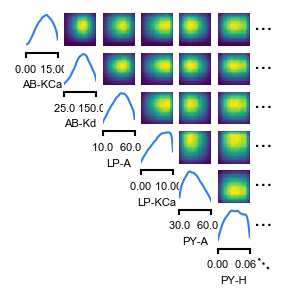

In [22]:
import matplotlib.patheffects as pe

with mpl.rc_context(fname='../.matplotlibrc'):

    labels_ = viz.get_labels_8pt(params)
    labels_[9] += ''

    fig, axes = samples_nd(samples=[thetas[:100000]],
                           subset=[4,5,11,12,19,22], # ,25,26,28
                           limits=lims,
                           ticks=lims,
                           tick_labels=all_labels,
                           fig_size=(17.0*0.17, 17.0*0.17),
                           labels=labels_,
                           scatter_offdiag={'rasterized':True, 'alpha':1.0},
                           samples_colors=[col['SNPE']],
                           diag=['kde'],
                           upper=['kde'],
                           hist_offdiag={'bins':50})
    
    plt.savefig(PANEL_X, facecolor='None', transparent=True)
    plt.show()

In [23]:
prior = netio.create_prior(params, log=True)
params_mean = prior.mean
params_std = prior.std

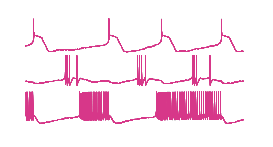

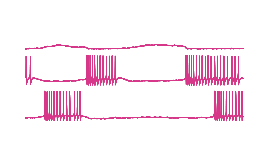

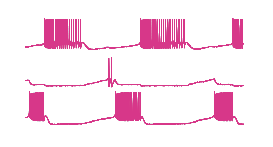

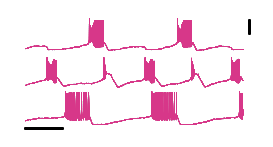

In [133]:
pyloric_sim = netio.create_simulators(params)
summ_stats = netio.create_summstats(params)

offsets = [127000]
scale_bar_ = [False, False, False, True]
counter = 0

panels = [PANEL_Y1, PANEL_Y2, PANEL_Y3, PANEL_Y4]

with mpl.rc_context(fname='../.matplotlibrc'):

    for my_count, k in enumerate([4,6,9,17]): # [4,6,9,10]
        fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(3.18, 2.08*3/4))

        theta = thetas[k]
        target_params = theta * prior.std + prior.mean

        out_target = pyloric_sim[0].gen_single(deepcopy(target_params), seed_sim=True, to_seed=8) # params.true_params gives the synaptic strengths #  165000

        _ = viz_samples.vis_sample_plain_bit_more_31DSynthetic(pyloric_sim[0], summ_stats, target_params, voltage_trace=out_target, test_idx=[0], case='high_p', col=[col['INCONSISTENT'], col['INCONSISTENT'], col['INCONSISTENT']], axV=ax, scale_bar=scale_bar_[my_count], time_len=115000, fontscale=1.0, linescale=1.2, legend=False, offset=offsets[0],
                                     title='Sample along the path of high probability in Prinz format', date_today='190910_samples_small', counter=counter, save_fig=False)
        plt.savefig(panels[my_count], facecolor='None', transparent=True, dpi=300, bbox_inches='tight')
        plt.show()

# Panel C: summary statistics

### Generate summstats from factorized posterior

In [53]:
pyloric_sim = netio.create_simulators(params)
summ_stats = netio.create_summstats(params)

offsets = [127000]
scale_bar_ = [False, False, False, True]
counter = 0

panels = [PANEL_Y1, PANEL_Y2, PANEL_Y3, PANEL_Y4]
start_index = 100
num_sim_samples = 500

with mpl.rc_context(fname='../.matplotlibrc'):
    
    all_ss = []

    for k in range(start_index, start_index+num_sim_samples):
        theta = thetas[k]
        target_params = theta * prior.std + prior.mean

        #out_target = pyloric_sim[0].gen_single(deepcopy(target_params), seed_sim=True, to_seed=8) # params.true_params gives the synaptic strengths #  165000
        #ss = summ_stats.calc([out_target])[0]
        #all_ss.append(ss)
#np.savez('results/summstats_factorized_{}posteriorSamples.npz'.format(num_sim_samples), all_ss=all_ss)

/Users/deismic/anaconda3/envs/lfi_prinz/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/deismic/anaconda3/envs/lfi_prinz/lib/python3.7/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)


In [3]:
all_ss = np.load('results/summstats_factorized_500posteriorSamples.npz')['all_ss']

In [73]:
num_noNan = 0
ss_noNan = []
for s in all_ss:
    if not np.any(np.isnan(s)):
        num_noNan += 1
        ss_noNan.append(s)
print('Fraction of bad samples:   ', (500-num_noNan)/500)

Fraction of bad samples:    0.734


### Generate summary stats from normal posterior

In [61]:
pyloric_sim = netio.create_simulators(params)
summ_stats = netio.create_summstats(params)

offsets = [127000]
scale_bar_ = [False, False, False, True]
counter = 0

panels = [PANEL_Y1, PANEL_Y2, PANEL_Y3, PANEL_Y4]
start_index = 0
num_sim_samples = 500

with mpl.rc_context(fname='../.matplotlibrc'):
    
    all_ss = []

    for k in range(start_index, start_index+num_sim_samples):
        theta = samples_MAF[k]
        target_params = theta * prior.std + prior.mean

        #out_target = pyloric_sim[0].gen_single(deepcopy(target_params), seed_sim=True, to_seed=8) # params.true_params gives the synaptic strengths #  165000
        #ss = summ_stats.calc([out_target])[0]
        #all_ss.append(ss)
#np.savez('results/summstats_{}posteriorSamples.npz'.format(num_sim_samples), all_ss=all_ss)

/Users/deismic/anaconda3/envs/lfi_prinz/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/deismic/anaconda3/envs/lfi_prinz/lib/python3.7/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)


In [62]:
all_ss_posterior = np.load('results/summstats_500posteriorSamples.npz')['all_ss']

In [63]:
num_noNan = 0
ss_noNan_posterior = []
for s in all_ss_posterior:
    if not np.any(np.isnan(s)):
        num_noNan += 1
        ss_noNan_posterior.append(s)
print('Fraction of bad samples:   ', (500-num_noNan)/500)

Fraction of bad samples:    0.208


### Generate figures

In [74]:
from print_helper import get_summ_stat_name, get_summ_stat_name_text, get_synapse_name, get_summ_stat_name_asterisk

In [75]:
names = []
for num in range(15):
    names.append(get_summ_stat_name_text(num))

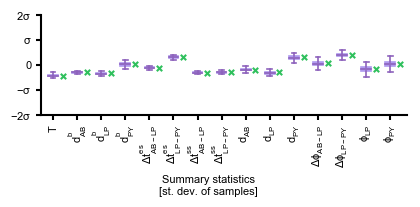

In [124]:
import seaborn as sns
import pandas as pd

norm_ss = (np.asarray(ss_noNan_posterior)[:,:15]-stats_mean[:15])/stats_std[:15]

with mpl.rc_context(fname='../.matplotlibrc'):
    fig, ax = plt.subplots(1,1, figsize=(3.5*1.35, 1.3))
    plt.scatter(np.arange(15)+0.4, (summstats_experimental[:15]-stats_mean[:15])/stats_std[:15], marker='x', s=15.0, color=col['GT'])
    df = pd.DataFrame(np.asarray(norm_ss))

    box = sns.boxplot(data=df, width=0.4, fliersize=.0, linewidth=1.2) # , color='#0570b0'
    for i, patch in enumerate(box.artists):
        r, g, b, a = patch.get_facecolor() # r, g, b, a = patch.get_facecolor()
        patch.set_facecolor(col['CONSISTENT2']) # patch.set_facecolor((r, g, b, .6))
        patch.set_edgecolor(col['CONSISTENT2'])
        for j in range(i*6,i*6+6):
            line = ax.lines[j]
            line.set_color(col['CONSISTENT1'])
            line.set_mfc(col['CONSISTENT1'])
            line.set_mec(col['CONSISTENT1'])
        
    ax.set_ylim([-2,2])
    ax.set_xlim([-0.5,14.7])
    ax.set_xticklabels(names, rotation='vertical')
    ax.set_yticks([-2, -1, 0, 1, 2])
    ax.set_yticklabels(['$\mathdefault{-2} \sigma$', '$\mathdefault{-}\sigma$', '0', '$\sigma$', '$\mathdefault{2} \sigma$'])
    ax.text(0.33,  -0.68, 'Summary statistics', transform=ax.transAxes)
    ax.text(0.322, -0.80, '[st. dev. of samples]', transform=ax.transAxes)
    plt.savefig(PANEL_Z1, facecolor='None', transparent=True, dpi=300, bbox_inches='tight')
    plt.show()

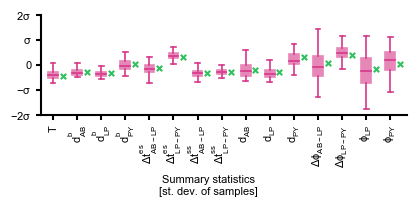

In [100]:
import seaborn as sns
import pandas as pd

norm_ss = (np.asarray(ss_noNan)[:,:15]-stats_mean[:15])/stats_std[:15]

with mpl.rc_context(fname='../.matplotlibrc'):
    fig, ax = plt.subplots(1,1, figsize=(3.5*1.35, 1.3))
    plt.scatter(np.arange(15)+0.4, (summstats_experimental[:15]-stats_mean[:15])/stats_std[:15], marker='x', s=15.0, color=col['GT'])
    df = pd.DataFrame(np.asarray(norm_ss))

    box = sns.boxplot(data=df, width=0.4, fliersize=.0, linewidth=1.2) # , color='#0570b0'
    for i, patch in enumerate(box.artists):
        r, g, b, a = patch.get_facecolor() # r, g, b, a = patch.get_facecolor()
        patch.set_facecolor(1-((1-np.asarray(col['INCONSISTENT'])))*0.6) # patch.set_facecolor((r, g, b, .6))
        patch.set_edgecolor(1-((1-np.asarray(col['INCONSISTENT'])))*0.6) # WANT A BRIGHTER ONE!
        for j in range(i*6,i*6+6):
            line = ax.lines[j]
            line.set_color(col['INCONSISTENT'])
            line.set_mfc(col['INCONSISTENT'])
            line.set_mec(col['INCONSISTENT'])
        
    ax.set_ylim([-2,2])
    ax.set_xlim([-0.5,14.7])
    ax.set_xticklabels(names, rotation='vertical')
    ax.set_yticks([-2, -1, 0, 1, 2])
    ax.set_yticklabels(['$\mathdefault{-2} \sigma$', '$\mathdefault{-}\sigma$', '0', '$\sigma$', '$\mathdefault{2} \sigma$'])
    ax.text(0.33,  -0.68, 'Summary statistics', transform=ax.transAxes)
    ax.text(0.322, -0.80, '[st. dev. of samples]', transform=ax.transAxes)
    plt.savefig(PANEL_Z2, facecolor='None', transparent=True, dpi=300, bbox_inches='tight')
    plt.show()

# Assemble figure

In [102]:
color_mixture = 0.5 * (np.asarray(list(col['CONSISTENT1'])) + np.asarray(list(col['CONSISTENT2'])))

In [103]:
import time
import IPython.display as IPd

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [142]:
from svgutils.compose import *

### from svgutils.compose import *
# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_heading = {'size': '8pt', 'font': 'Arial'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#D73789'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

sizefactor = 1.0
dshift = 0.5*factor_svg

top_left_x_AB = 295.9
top_left_y_AB = 287.4

top_left_x_1 = 380
top_left_y_1 = 355

top_left_x_2 = 333
top_left_y_2 = 306

top_left_x_3 = 429
top_left_y_3 = 402

square_size = 48.2
small_square = 6.0

rectangle_col = 'black'
smallRect_col = 'blue'
rectangle_width = 1.0
    
f = Figure('20.3cm', '12.1cm',

    Panel(
          SVG(PANEL_X).scale(svg_scale).move(0, 15*factor_svg),
          Text("a", 0*factor_svg, 17*factor_svg, **kwargs_text),
          #Text("Na CaT CaS A KCa Kd H leak", 6.5*factor_svg, 63.0*factor_svg, **kwargs_heading),
    ).move(0*factor_svg, -14.5*factor_svg),
    
    Panel(
          SVG(PANEL_Y1).scale(svg_scale).move(0, 15*factor_svg),
          Text("b", -2*factor_svg, 17*factor_svg, **kwargs_text),
    ).move(53*factor_svg, -14.5*factor_svg),
    
    Panel(
          SVG(PANEL_Y2).scale(svg_scale).move(0, 15*factor_svg),
    ).move(95*factor_svg, -14.5*factor_svg),
           
    Panel(
          SVG(PANEL_Y3).scale(svg_scale).move(0, 15*factor_svg),
    ).move(53*factor_svg, 8.7*factor_svg),
    
    Panel(
          SVG(PANEL_Y4).scale(svg_scale).move(0, 15*factor_svg),
        Text("50 mV", 35.1*factor_svg, 20*factor_svg, **kwargs_text8pt),
        Text("500 ms", 4.1*factor_svg, 38.0*factor_svg, **kwargs_text8pt),
    ).move(95*factor_svg, 8.7*factor_svg),
           
    Panel(
          SVG(PANEL_Z1).scale(svg_scale).move(0, 15*factor_svg),
          Text("c", 0*factor_svg, 15*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 35.5*factor_svg),
           
    Panel(
          SVG(PANEL_Z2).scale(svg_scale).move(0, 15*factor_svg),
    ).move(72*factor_svg, 35.5*factor_svg),
    
)

!mkdir -p fig
f.save("fig/fig9_suppl_sampleMarginal.svg")
svg('fig/fig9_suppl_sampleMarginal.svg')